# Installation

In [1]:
from platform import python_version

print(python_version())

3.9.18


Also see the advanced tutorial to learn about adding constrained and unconstrained extension nodes to the query to capture new sources of variation, that is new and de novo gene programs, not in the reference dataset.

All ths installation was done in a conda enviroment. for **scarches** installation see folowing: https://docs.scarches.org/en/latest/installation.html

# Tips of models training 

+ The main hyperparameter that affects the quality of integration for the reference training is alpha_kl, the value of which is multiplied by the kl divergence term in the total loss.

+ If the visualized latent space looks like a single blob after the reference training, we recommend to decrease the value of alpha_kl. If the visualized latent space shows bad integration quality, we recommend to increase the value of alpha_kl. The good default value in most cases is alpha_kl = 0.5.

+ The required strength of group lasso regularization (alpha) depends on the number of used GPs and the size of the dataset. For 300–500 GPs, we recommend to use alpha = 0.7 and increase for larger numbers of GPs.

+ If soft mask in the reference training is used (soft_ext_mask=True in the model initialization), it is better to start with alpha_l1=0.5 (higher value means more constraints on how many genes are added to the gene sets) and use print_stats=True in the training for monitoring to check the reported “Share of deactivated inactive genes: ​__” is around 95% (0.95) at the end and stays so at the final 10 epochs of training. If it is much smaller, alpha_l1 should be increased by a small value (around 0.05), and if it is 100% (1.) then alpha_l1 should be decreased.

+ Using new terms (n_ext) in the reference training is not recommended.

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import scanpy as sc
import pandas as pd
import torch
import scarches as sca
import numpy as np
import gdown

 captum (see https://github.com/pytorch/captum).


In [4]:
#torch.cuda
torch.cuda.is_available()

False

In [5]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

# Download reference and do preprocessing

In [6]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
From (redirected): https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0&confirm=t&uuid=feeb7499-7ae1-4953-acb4-fc91f8964b95
To: /home/aruna/Desktop/Analysis/Project1/Expimap/pbmc_tutorial.h5ad
100%|██████████| 231M/231M [00:04<00:00, 48.3MB/s] 


'pbmc_tutorial.h5ad'

In [7]:
adata = sc.read('pbmc_tutorial.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 32484 × 10851
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    layers: 'counts'

In [9]:
adata.obs

,batch,chemistry,data_type,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue,cell_type
index,,,,,,,,,,,,,,
AAACCTGCAGCGAACA-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD16+ Monocytes,0.047970,6379.0,1862.0,0,0.957719,Human,Oetjen,Bone_Marrow,CD16+ Monocytes
AAACCTGCATGTCCTC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD4+ T cells,0.024928,4172.0,1082.0,0,0.425532,Human,Oetjen,Bone_Marrow,CD4+ T cells
AAACCTGGTCGACTGC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.051907,6608.0,1618.0,0,0.773111,Human,Oetjen,Bone_Marrow,CD14+ Monocytes
AAACCTGGTCGCTTCT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.041716,5034.0,1413.0,0,0.641188,Human,Oetjen,Bone_Marrow,CD14+ Monocytes
AAACCTGTCCCGACTT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,NKT cells,0.043522,3998.0,1127.0,0,0.452426,Human,Oetjen,Bone_Marrow,NKT cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,CD14+ Monocytes,0.059215,3006.0,1111.0,3,0.825529,Human,Sun,PBMCs,CD14+ Monocytes
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,CD14+ Monocytes,0.051119,5810.0,1723.0,3,1.584353,Human,Sun,PBMCs,CD14+ Monocytes
TTTGTCATCATCATTC-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,NK cells,0.038078,2705.0,1209.0,3,0.978014,Human,Sun,PBMCs,NK cells


In [175]:
adata.X = adata.layers["counts"].copy()
adata.X

array([[ 6.,  0.,  0.,  1.,  0.,  0.,  2., ...,  0.,  0.,  0.,  3.,  1.,
         1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0., ...,  0.,  0.,  1.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  2.,  1.,  0.,  0.,  4., ...,  1.,  1.,  1.,  4.,  0.,
         0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  2., ...,  0.,  0.,  0.,  1.,  1.,
         0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., 29., ...,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  5., ...,  0.,  0.,  0.,  5.,  0.,
         0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  8., ...,  0.,  1.,  0.,  4.,  1.,
         0.,  0.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., ...,  0.,  0.,  1.,  1.,  0.,
         0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  0., ...,  0.,  0.,  1.,  0.,  1.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2., ...,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  3., ...,  0.,  0.,  1.,  3., 

Read the Reactome annotations, make a binary matrix where rows represent gene symbols and columns represent the terms, and add the annotations matrix to the reference dataset. The binary matrix of annotations is stored in adata.varm['I']. Note that only terms with minimum of 12 genes in the reference dataset are retained.

In [10]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/aruna/Desktop/Analysis/Project1/Expimap/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 2.73MB/s]


'reactome.gmt'

In [11]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

In [12]:
adata

AnnData object with n_obs × n_vars = 32484 × 10851
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    uns: 'terms'
    varm: 'I'
    layers: 'counts'

In [13]:
pd.DataFrame(adata.varm['I'])

,0,1,2,3,4,5,6,7,8,9,...,447,448,449,450,451,452,453,454,455,456
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Remove all genes which are not present in the Reactome annotations.

In [14]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. However, for more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out all annotations (terms) with less than 12 genes

In [16]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any of the terms after selection of HVGs.

In [17]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put the counts data back to adata.X

In [18]:
adata.X = adata.layers["counts"].copy()

# Create expiMap model and train it on reference dataset

In [19]:
adata

AnnData object with n_obs × n_vars = 32484 × 1970
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'
    layers: 'counts'

In [20]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1970 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 253
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  253 0 0 4 1970
	with hard mask.
Last Decoder layer: softmax


Set the alpha hyperparameter. This regulates the strength of group lasso regularization of annotations (terms). Higher value means that a larger number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

See also https://docs.scarches.org/en/latest/training_tips.html for the recommendation on hyperparameter choice.

In [21]:
ALPHA = 0.7

In [22]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (32484, 1970)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |█████████-----------| 46.0%  - epoch_loss: 826.1930336765 - epoch_recon_loss: 799.7445084351 - epoch_kl_loss: 52.8970530481 - val_loss: 827.2829660269 - val_recon_loss: 801.3496539776 - val_kl_loss: 51.866622924854965
ADJUSTED LR
 |██████████----------| 53.0%  - epoch_loss: 825.7903338436 - epoch_recon_loss: 799.4358632450 - epoch_kl_loss: 52.7089439292 - val_loss: 826.0651151217 - val_recon_loss: 800.1923382099 - val_kl_loss: 51.7455608661
ADJUSTED LR
 |███████████---------| 57.8%  - epoch_loss: 822.3150424208 - epoch_recon_loss: 796.0650176336 - epoch_kl_loss: 52.5000488581 - val_loss: 827.1884084848 - val_recon_loss: 801.3569688063 - val_kl_loss: 51.6628821446
ADJUSTED LR
 |████████████--------| 61.0%  - epoch_loss: 824.6377832671 - epoch_recon_loss: 798.2579844112 - epoch_kl_loss: 52.7596014931 - val_loss: 827.6830913837 - val_recon_loss: 801.7829777644 - val_kl_loss: 51.80022

In [23]:
MEAN = False

In [24]:
adata

AnnData object with n_obs × n_vars = 32484 × 1970
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'
    layers: 'counts'

In [25]:
pd.DataFrame(intr_cvae.get_latent(mean=MEAN, only_active=True)) 

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,-0.994066,-2.148526,-2.253075,-0.006362,1.844650,-0.657545,-1.263856,1.898839,0.240906,-1.172001,...,1.611645,-0.085393,-1.397593,0.074705,-1.381076,0.346399,1.346284,0.719864,0.097636,1.020451
1,-0.165733,0.097521,0.825476,0.970089,-0.336043,-0.787839,0.575878,-0.297485,0.753588,-1.292437,...,0.301850,-0.970962,1.188280,-1.323396,1.455832,0.766956,0.147889,1.419960,-1.209087,-0.787555
2,-1.531714,-0.279975,-1.244973,0.004111,-1.265279,0.006395,-2.215349,0.783294,0.613827,1.981042,...,1.799087,1.801983,-1.521718,-0.187729,-0.565131,0.411041,-0.613609,0.058547,-0.564828,-0.663277
3,-0.099181,-0.321918,0.163191,1.521167,-2.288208,0.504706,-1.569598,0.603977,-0.316845,-0.969080,...,2.175947,0.149713,-1.775920,0.454725,0.473546,-0.305774,0.581565,-1.249866,-0.716223,2.457976
4,0.106346,-0.475606,-1.039129,-0.296600,0.591547,-0.656250,0.558091,0.177809,-1.574007,-0.864444,...,-0.960384,0.109633,0.261587,1.125681,-0.043348,1.247155,-1.610755,0.965354,0.393780,0.150628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32479,-0.091775,2.018162,0.683613,1.051859,-0.383009,1.761100,-1.690144,1.140156,1.458564,-1.067460,...,1.865493,-1.348925,-1.328649,-0.109316,-0.862092,-0.469980,0.213458,-0.267867,1.089621,-0.148187
32480,-0.889148,-0.467840,1.036680,1.678482,0.293954,0.184013,-1.839090,1.165802,1.712530,0.281210,...,1.789421,0.397753,-1.295941,0.707294,-0.030903,0.767664,-0.130689,-0.154288,-0.801743,0.381436
32481,-0.271954,-0.356054,-0.333268,1.186879,-0.392416,1.213037,-0.714736,0.623858,0.034786,-1.169690,...,-0.840574,-1.234118,-0.331395,-0.358894,-1.111300,0.123591,0.324749,-2.592471,0.586411,0.253987
32482,-0.198609,-0.313365,1.029591,0.978747,0.574138,2.080164,-0.669942,1.331936,0.242998,0.345644,...,-0.562325,-0.203984,-0.317148,-1.788823,0.477412,-0.777715,0.416271,-0.464294,1.224197,-2.254160


Plot the latent space of the reference.

In [26]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [27]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [28]:
sc.tl.umap(adata)

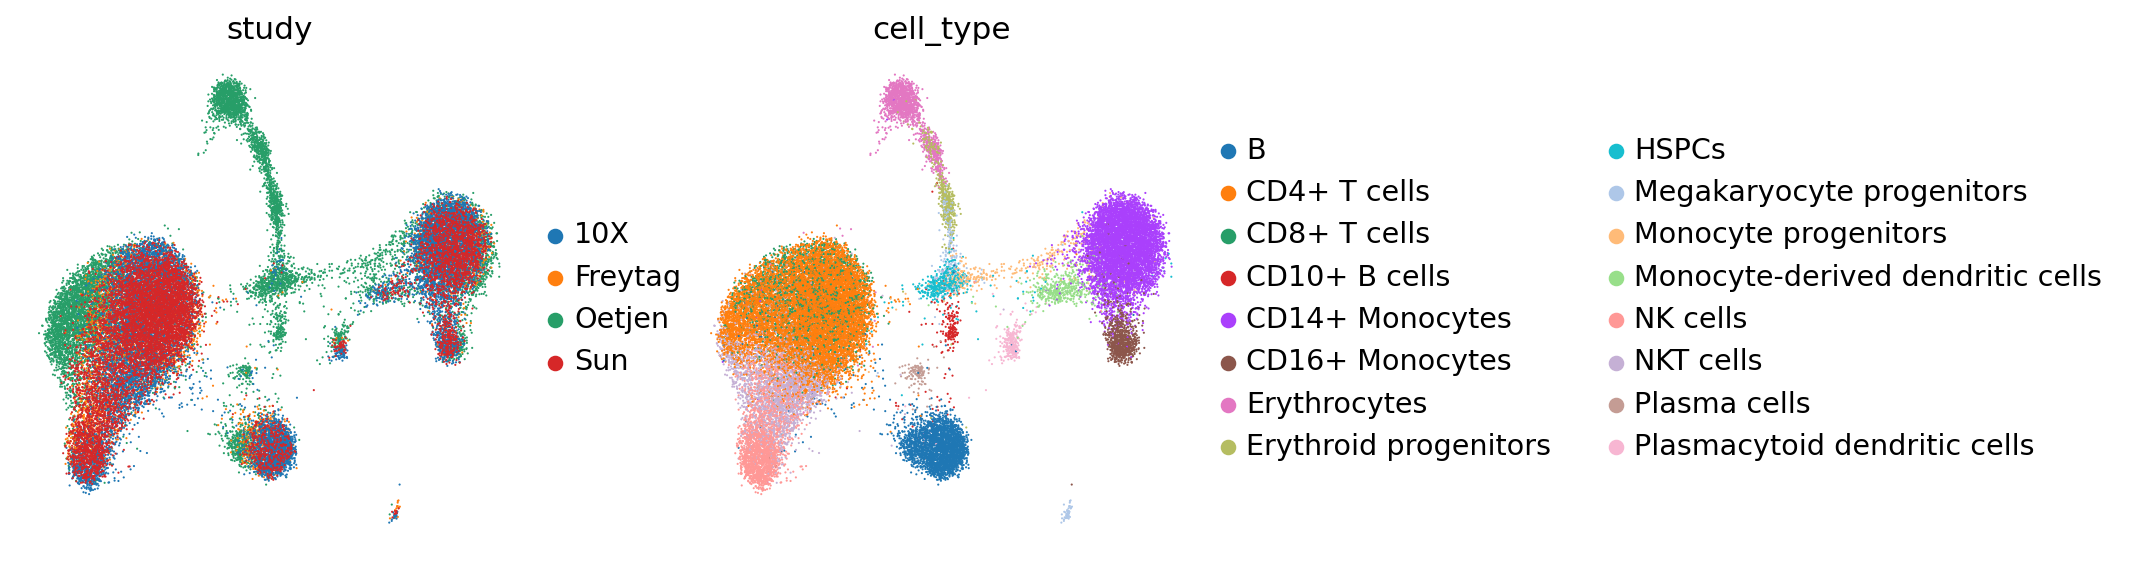

In [29]:
sc.pl.umap(adata, color=['study', 'cell_type'], frameon=False)

# Downaload the query dataset for reference mapping

The Kang dataset contains control and IFN-beta stimulated cells. We use this as the query dataset.

In [30]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG
To: /home/aruna/Desktop/Analysis/Project1/Expimap/kang_tutorial.h5ad
100%|██████████| 26.8M/26.8M [00:00<00:00, 48.8MB/s]


'kang_tutorial.h5ad'

In [31]:
kang = sc.read('kang_tutorial.h5ad')[:, adata.var_names].copy()

In [33]:
kang

AnnData object with n_obs × n_vars = 13576 × 1970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

In [34]:
kang.obs['study'] = 'Kang'
kang.uns['terms'] = adata.uns['terms']

In [35]:
kang

AnnData object with n_obs × n_vars = 13576 × 1970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study'
    uns: 'terms'

# Initlizling the model for query training

In [36]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae)

AnnData object with n_obs × n_vars = 13576 × 1970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study'
    uns: 'terms'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1970 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 253
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  253 0 0 5 1970
	with hard mask.
Last Decoder layer: softmax


In [37]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, 
                  seed=2020, use_early_stopping=True)

Preparing (13576, 1970)
Instantiating dataset
 |████████------------| 43.2%  - val_loss: 482.9477899725 - val_recon_loss: 475.1938337846 - val_kl_loss: 77.5395487005
ADJUSTED LR
 |█████████-----------| 45.0%  - val_loss: 482.9235617898 - val_recon_loss: 475.1608220881 - val_kl_loss: 77.6273914684
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 158


In [40]:
#q_intr_cvae.save('query_kang_tutorial')

In [39]:
pd.DataFrame(q_intr_cvae.get_latent(mean=MEAN, only_active=True)) 

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,-1.730848,-0.290074,0.520480,1.562144,-0.514757,-0.216815,-1.720310,1.574773,-2.028379,-0.656753,...,2.598456,-0.530386,-1.672322,-1.237587,0.870013,-1.868195,-1.187756,-0.855665,0.123459,1.013577
1,-0.553009,0.358559,1.268882,1.106284,-0.288666,0.365344,-1.697895,0.545991,-0.930748,1.723842,...,0.811502,-0.355993,-2.068753,0.987491,0.308644,0.319966,0.685332,-0.938892,-0.332217,-1.065957
2,0.042560,-0.153906,-0.186416,0.218535,0.136931,-0.283195,-1.763566,1.153680,0.229727,0.246418,...,1.280866,-0.121288,-2.182107,-1.102841,-0.429448,0.077834,-2.730367,-0.402180,-0.461404,1.236996
3,-0.915972,1.086459,0.446672,-0.851626,-1.672456,-0.154307,0.647510,-2.087192,0.248423,-1.338883,...,-0.294172,-0.878268,0.048842,0.410901,0.284951,0.070978,0.047141,1.084588,0.225583,0.043770
4,-0.566183,1.506391,-1.566151,0.441954,0.044679,-0.997701,-1.228151,1.390516,-0.055220,-1.654163,...,1.304915,-0.974011,-2.506026,0.398808,0.000426,-0.975226,-0.653512,-0.007300,0.317844,0.938290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,0.277515,-0.650574,0.165993,0.437107,1.300219,-1.478964,-0.940414,0.544903,-1.508670,-0.706572,...,2.390248,-0.251701,-2.036307,-0.064101,-0.718348,-1.325349,1.024112,2.084454,1.164002,-0.454074
13572,-0.239455,0.707854,-0.684806,0.176203,-0.459732,-1.292841,-0.725300,-0.619591,-1.989820,1.655425,...,0.090515,0.497410,-0.633733,-0.363058,1.062923,-0.038913,-0.999815,-0.191574,-0.585297,-0.407451
13573,-0.726591,0.101974,-0.924336,0.690016,0.425283,1.030706,0.943161,0.987182,1.345836,-1.643590,...,-0.520958,0.544514,1.203015,0.486687,-0.625268,-0.932465,1.606979,0.587435,1.161237,0.809820
13574,-0.134337,0.188053,-0.324587,-0.431608,0.499575,-0.836824,0.197969,-0.864960,-0.757745,-0.392000,...,-0.369424,1.274075,0.040290,-0.514765,0.021752,0.521990,1.725105,-2.540042,0.842508,-0.002947


# Get latent representation of reference + query dataset

In [40]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [41]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, 
                                                  kang_pbmc.obs['study'], mean=MEAN, only_active=True)

In [42]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [43]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

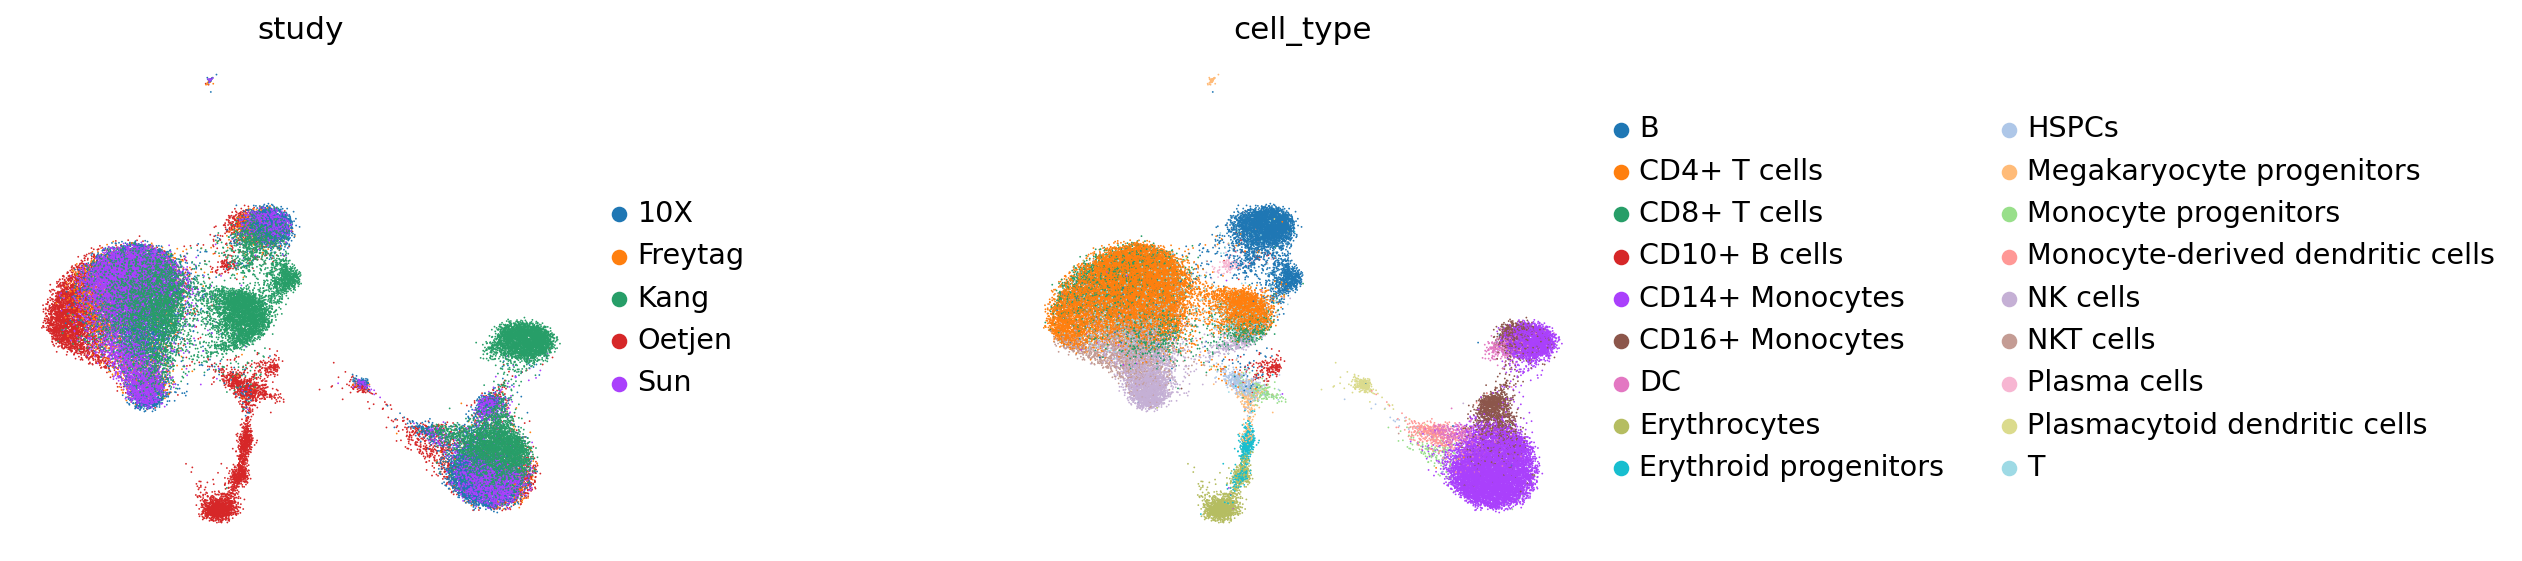

In [44]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type'], frameon=False, wspace=0.6)

In [45]:
kang_pbmc

AnnData object with n_obs × n_vars = 46060 × 1970
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'batch_join', 'condition_joint'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    uns: 'terms', 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
    obsm: 'X_cvae', 'X_umap'
    obsp: 'distances', 'connectivities'

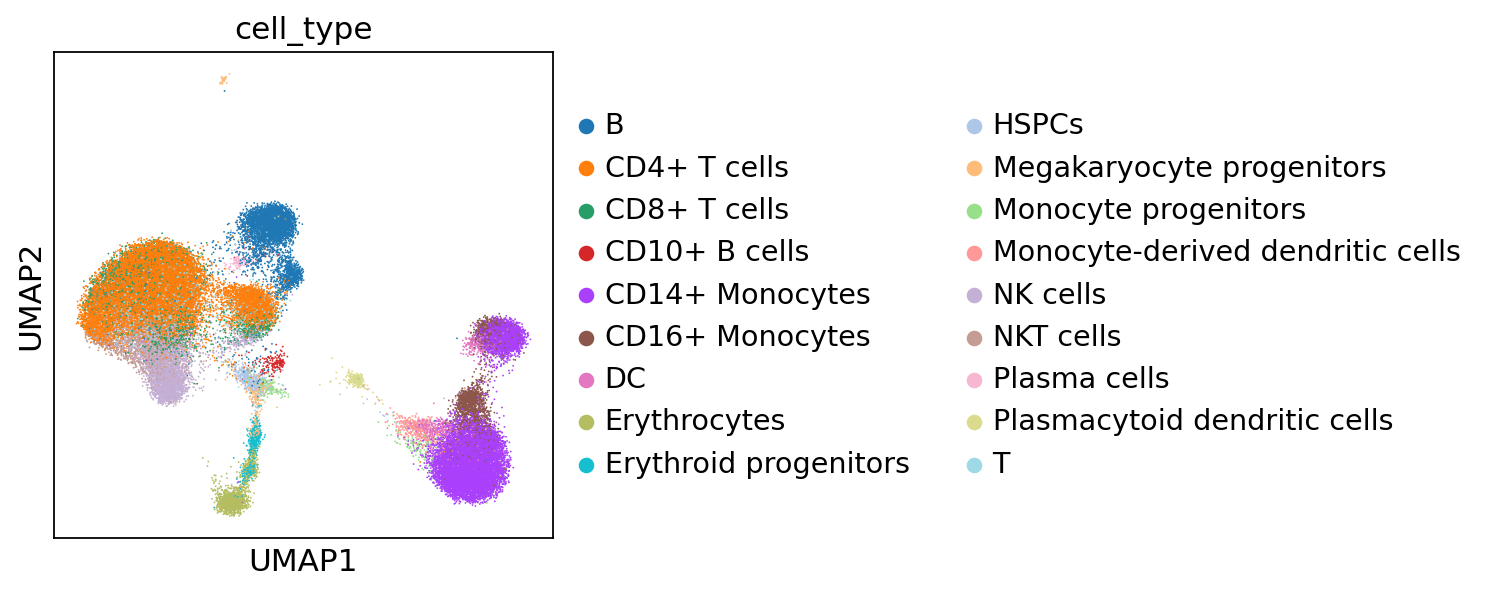

In [46]:
sc.pl.umap(kang_pbmc, color='cell_type', frameon=True, wspace=0.6)

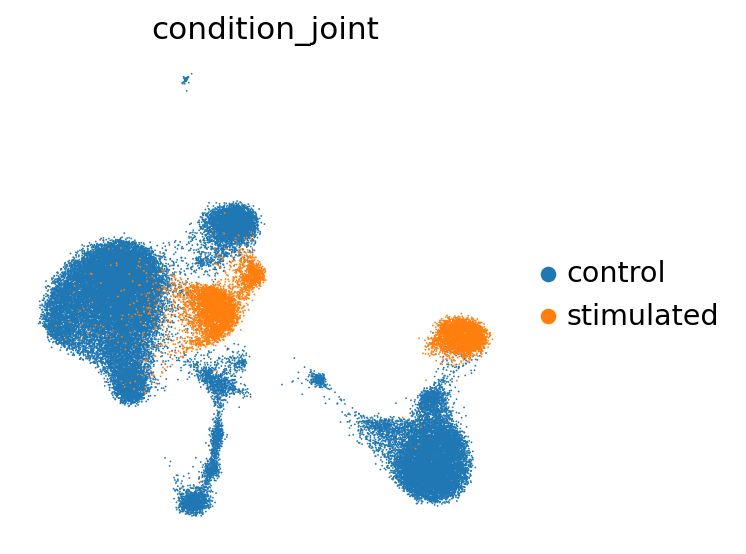

In [47]:
sc.pl.umap(kang_pbmc, color='condition_joint', frameon=False, wspace=0.6)

Calculate directions of upregulation for each latent score and put them to kang_pbmc.uns['directions'].

In [54]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for condition in reference + query using Bayes Factors.

In [55]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', 
                          use_directions=True, adata=kang_pbmc)

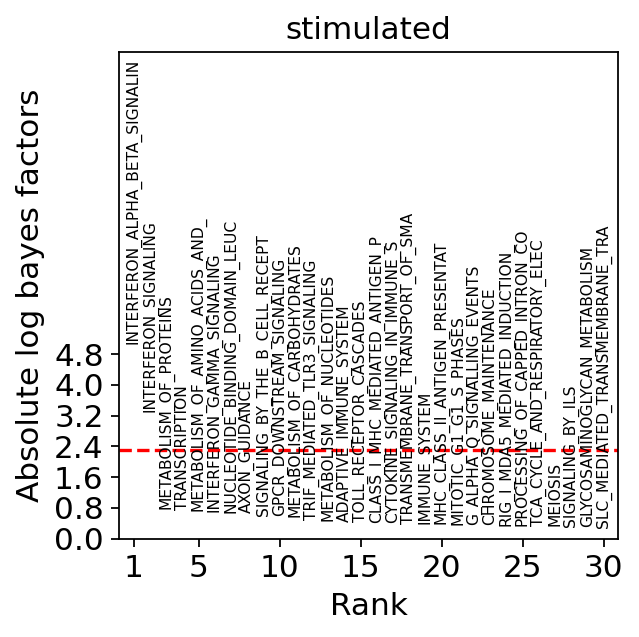

In [56]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

As expected, INTERFERON_ALPHA_BETA_SIGNALING is the top differential program in stimulated compared to control cells.

Plot the latent variables for query + reference corresponding to the annotations ‘INTERFERON_SIGNALING’, ‘SIGNALING_BY_THE_B_CELL_RECEPTOR’, ‘INTERFERON_ALPHA_BETA_SIGNALING’.

In [57]:
terms = kang_pbmc.uns['terms']
select_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'SIGNALING_BY_THE_B_CELL_RECEPT']
idx = [terms.index(term) for term in select_terms]

In [58]:
idx

[224, 223, 46]

In [59]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN)
           * kang_pbmc.uns['directions'])[:, idx]

Multiplying the latent varibales by the calculated directons to ensure positive latent scores corresponf to upregulation.

In [60]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 1]

kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 2]


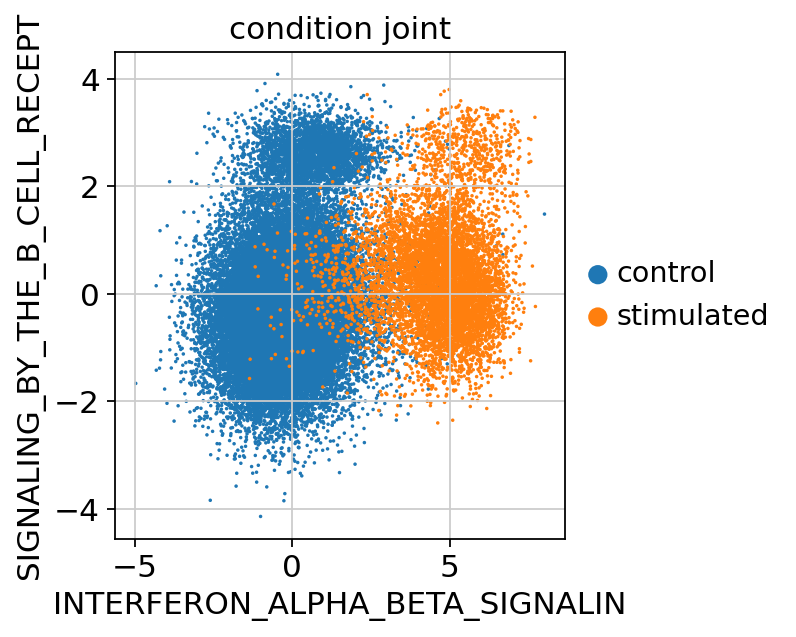

In [61]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT',
              color='condition_joint', size=10)

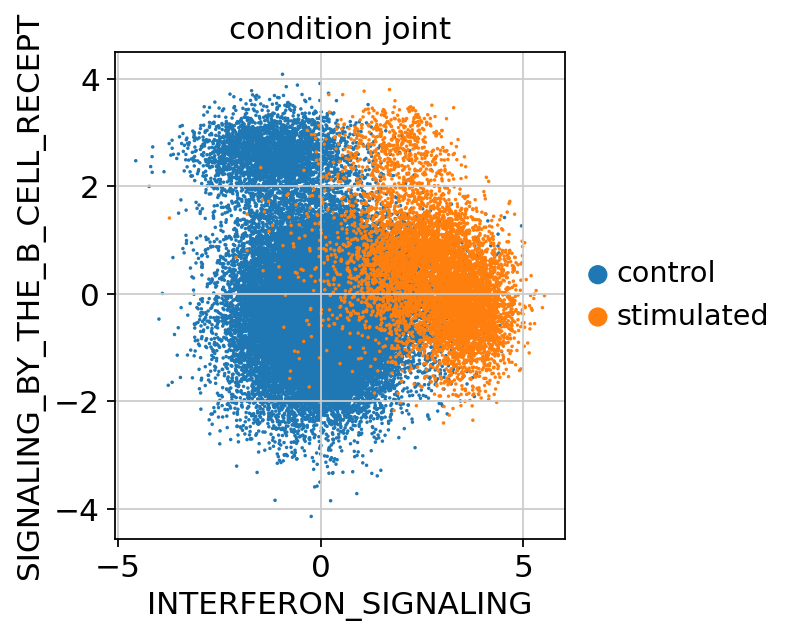

In [62]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', 
              color='condition_joint', size=10)

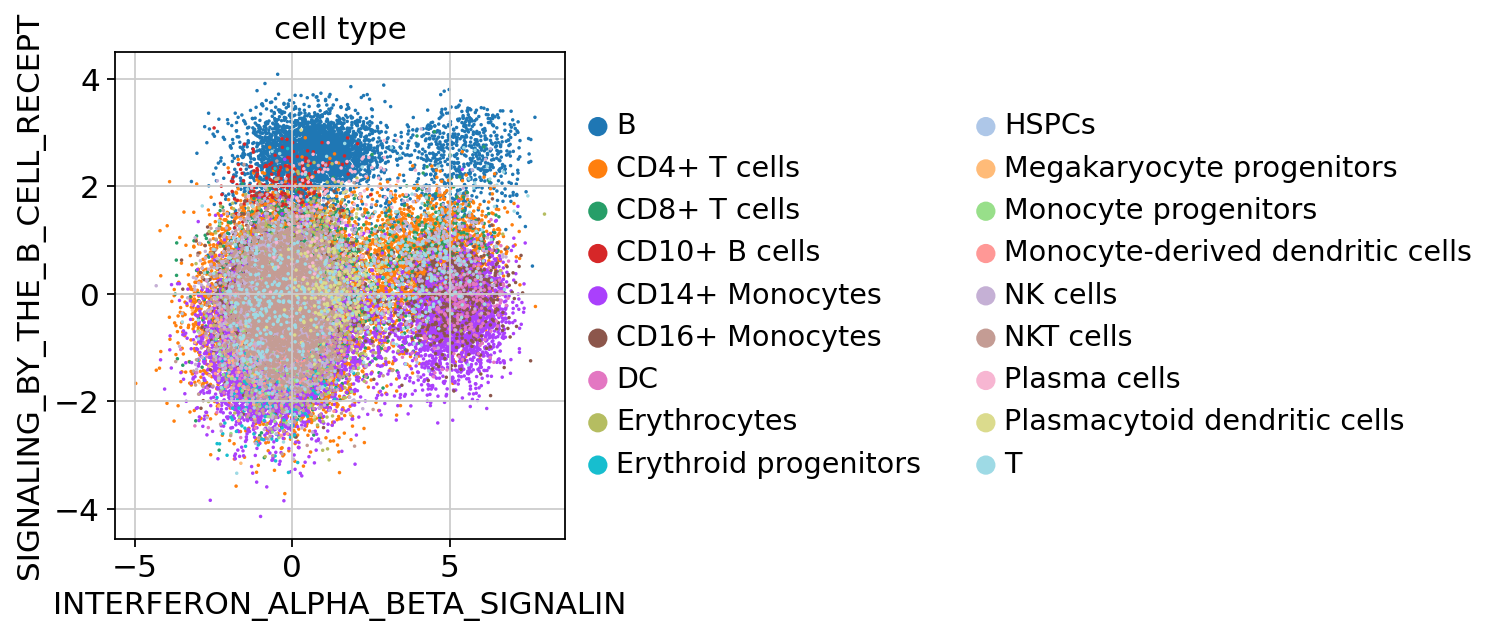

In [63]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', 
              color='cell_type', size=10)